Using the algorithms from this paper: https://arxiv.org/pdf/2304.09224v2 testing the cats and dogs dataset


In [95]:
%pip install torch pennylane torchvision matplotlib torchmetrics

# imports
import torch.nn as nn
import pennylane as qml
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from IPython.display import display
import torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [47]:
%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\prana\.cache\kagglehub\datasets\bhavikjikadara\dog-and-cat-classification-dataset\versions\1


## Overall structure

```
ALGORITHM: HQNN-Parallel
INPUT: Image x of size 28×28 (for MNIST)
OUTPUT: Class probability distribution over 10 classes

FUNCTION HQNN_Parallel(x):
    // Classical Convolutional Feature Extraction
    features = ClassicalConvolutionalBlock(x)

    // Hybrid Dense Processing
    quantum_output = ParallelQuantumLayers(features)

    // Final Classification
    output = ClassicalDenseLayer(quantum_output)

    RETURN output
```

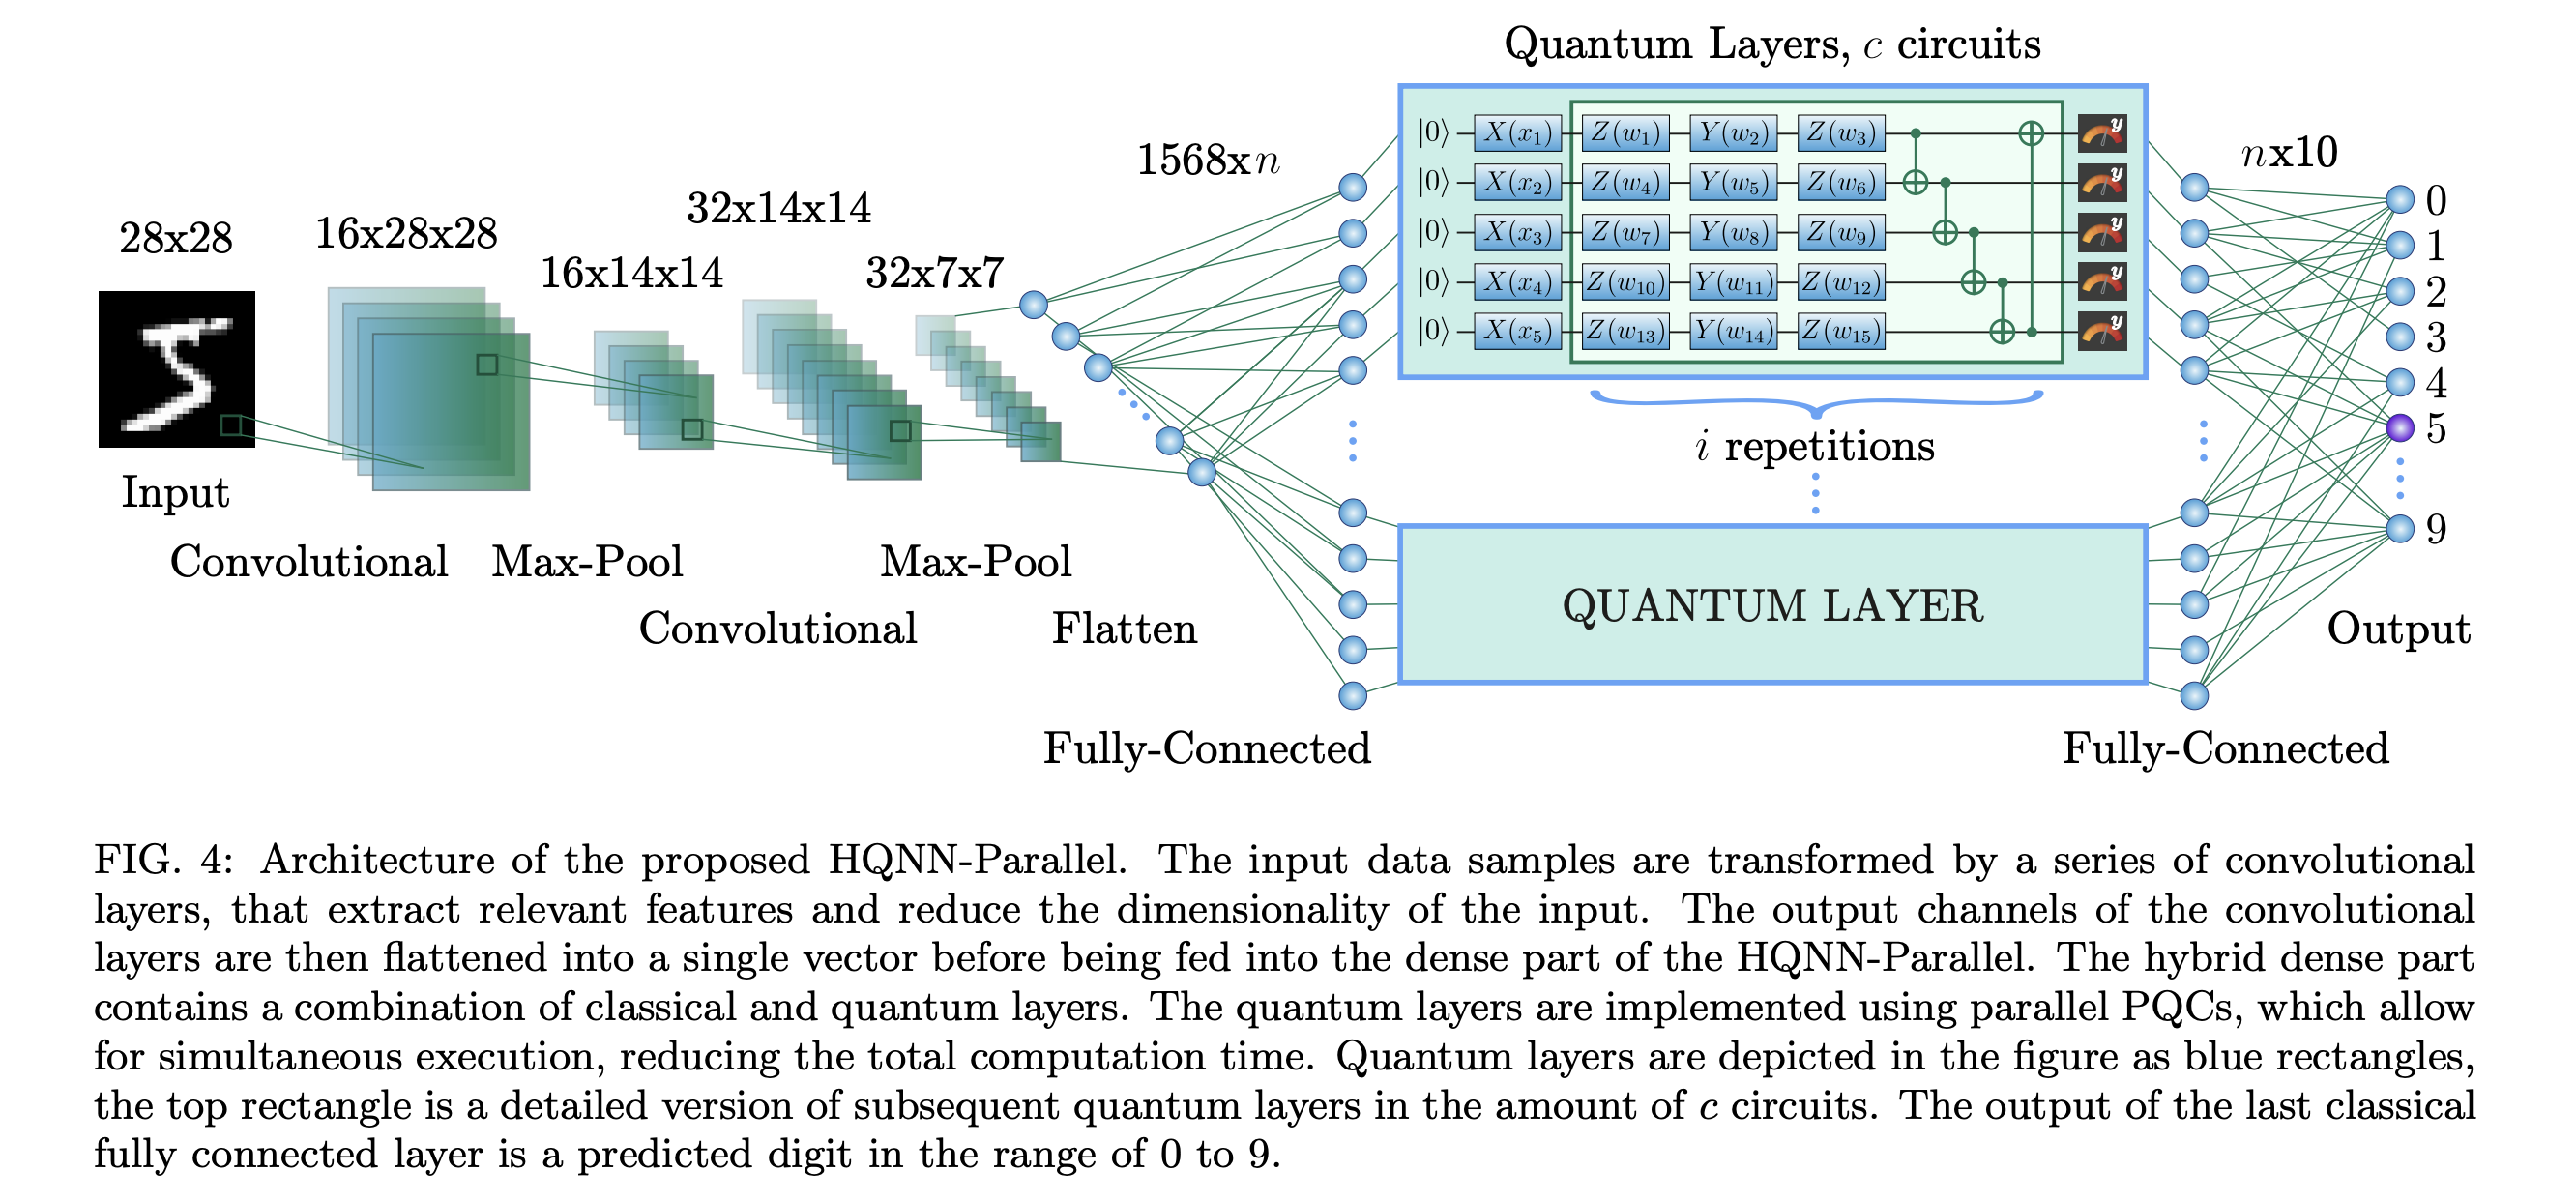


## Classical Convolutional Feature Extraction

```
FUNCTION ClassicalConvolutionalBlock(input_image):
    // First Convolutional Block
    conv1 = Conv2D(input_channels=1, output_channels=16, kernel_size=5×5,
                   stride=1, padding=2)(input_image)
    norm1 = BatchNormalization(conv1)
    relu1 = ReLU(norm1)
    pool1 = MaxPool2D(kernel_size=2×2)(relu1)  // Output: 16×14×14

    // Second Convolutional Block
    conv2 = Conv2D(input_channels=16, output_channels=32, kernel_size=5×5,
                   stride=1, padding=2)(pool1)
    norm2 = BatchNormalization(conv2)
    relu2 = ReLU(norm2)
    pool2 = MaxPool2D(kernel_size=2×2)(relu2)  // Output: 32×7×7

    // Flatten for dense layers
    flattened = Flatten(pool2)  // Output: 1568 features

    RETURN flattened
```


In [48]:
ClassicalConvBlock = nn.Sequential(
    # First Convolutional Block
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # Output: (batch, 16, 14, 14)

    # Second Convolutional Block
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # Output: (batch, 32, 7, 7)

    # Flatten for dense layers
    nn.Flatten() # Output: (batch, 1568)
)

### Testing the ClassicalConvBlock


Image tensor shape: torch.Size([1, 375, 500])
Label: 0
Min value: 0.01568627543747425, Max value: 1.0
PyTorch tensor shape for model: torch.Size([1, 1, 375, 500])


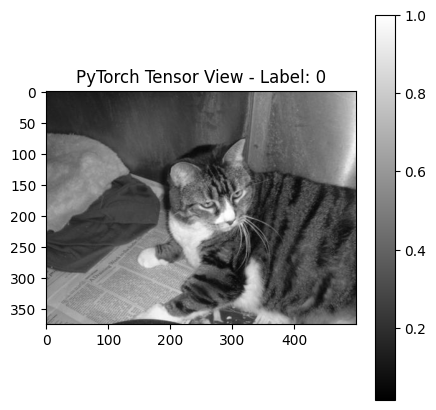

Output shape of ClassicalConvBlock: torch.Size([1, 372000])


In [96]:


# Load MNIST dataset using torchvision
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure 1 channel like MNIST
    transforms.ToTensor()
])

# Your local path to PetImages
data_dir = r"C:\Users\prana\OneDrive - University of Maryland\Ionq\quantum-classification\HQNN\data\PetImages"

train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


# Select a single image
img_idx = 2000  # Choose an arbitrary index
img_tensor, label = train_dataset[img_idx]  # The transform is applied automatically

# Print information about the image
# The tensor is already in [channels, height, width] format
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Label: {label}")
print(f"Min value: {img_tensor.min()}, Max value: {img_tensor.max()}")

# Add a batch dimension for processing with the model
# PyTorch expects format: [batch_size, channels, height, width]
img_tensor = img_tensor.unsqueeze(0)
print(f"PyTorch tensor shape for model: {img_tensor.shape}") 

# For visualization of tensor format
plt.figure(figsize=(5, 5))
# We use .squeeze() to remove the batch and channel dimensions for plotting
plt.imshow(img_tensor.squeeze().numpy(), cmap='gray')
plt.title(f"PyTorch Tensor View - Label: {label}")
plt.colorbar()
plt.grid(False)
plt.show()

# Test the convolutionalblock
features = ClassicalConvBlock(img_tensor)
print(f"Output shape of ClassicalConvBlock: {features.shape}")

## Parallel Quantum Layers

```
FUNCTION ParallelQuantumLayers(features):
    // First classical dense layer to prepare quantum input
    dense_features = DenseLayer(input_size=1568, output_size=n)(features)
    dense_features = BatchNormalization(dense_features)
    dense_features = ReLU(dense_features)

    // Divide features into c parallel quantum circuits
    // where n = c × q (c circuits, q qubits each)
    quantum_inputs = Split(dense_features, num_parts=c)

    // Process each part through parallel quantum circuits
    quantum_outputs = []
    FOR i = 1 TO c:
        qc_output = QuantumCircuit(quantum_inputs[i], qubits=q, depth=d)
        quantum_outputs.append(qc_output)

    // Concatenate all quantum outputs
    concatenated_output = Concatenate(quantum_outputs)

    RETURN concatenated_output
```

### Individual Quantum Circuit within each layer:

```
FUNCTION ParallelCircuit(input_vector, qubits, depth):
    // Initialize quantum state
    state = |0⟩^⊗qubits

    // Angle embedding: encode classical data into quantum state
    FOR j = 1 TO qubits:
        state = RX(input_vector[j]) × state  // Rotate around Y-axis

    // Variational quantum circuit with depth repetitions
    FOR layer = 1 TO depth:
        // Trainable rotation gates
        FOR j = 1 TO qubits:
            state = RX(θ_x[layer][j]) × state
            state = RY(θ_y[layer][j]) × state
            state = RZ(θ_z[layer][j]) × state

        // Entangling gates (CNOT operations)
        FOR j = 1 TO qubits-1:
            state = CNOT(j, j+1) × state

    // Measurement: compute expectation values
    measurements = []
    FOR j = 1 TO qubits:
        expectation = ⟨state| Pauli_Y[j] |state⟩
        measurements.append(expectation)

    RETURN measurements
```


In [97]:
class ParallelQuantumLayer(nn.Module):
    """
    A PyTorch module for the parallel quantum layers.
    
    This module includes a classical preprocessing layer and a set of parallel
    quantum circuits implemented with PennyLane. It's designed to be a drop-in
    replacement in a PyTorch model.
    """
    def __init__(self, n_qubits, n_circuits, depth, device='default.qubit', shots=None):
        """
        Args:
            n (int): The number of features coming from the CNN (e.g., 1568).
            n_qubits (int): The number of qubits in each quantum circuit.
            depth (int): The depth of the variational part of each quantum circuit.
            device (str): The PennyLane device to use.
            shots (int, optional): The number of shots for measurements. None for exact expectation.
        """
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_circuits = n_circuits
        self.total_quantum_features = n_circuits * n_qubits

        # --- 1. Classical Preprocessing Layer ---
        # This layer maps the flattened CNN output to the total number of features
        # required by all parallel quantum circuits.
        self.classical_preprocessor = nn.Sequential(
            nn.LazyLinear(self.total_quantum_features),
            nn.BatchNorm1d(self.total_quantum_features),
            nn.ReLU()
        )

        # --- 2. Quantum Device and Circuit Definition ---
        # We define a single quantum device and a QNode template.
        dev = qml.device(device, wires=n_qubits, shots=shots)

        @qml.qnode(dev, interface='torch', diff_method='adjoint')
        def quantum_circuit(inputs, weights):
            """The quantum circuit template for a single parallel layer."""
            # Reshape weights for easier indexing
            weights = weights.reshape(depth, 3, n_qubits)
            
            # Encode classical data using Angle Embedding
            # Scale inputs to [0, π] range for angle embedding
            # This ensures proper rotation angles for the quantum gates
            scaled_inputs = inputs * torch.pi
            qml.AngleEmbedding(scaled_inputs, wires=range(n_qubits), rotation='X')

            # Apply variational layers (trainable)
            for layer_id in range(depth):
                # Trainable rotation gates
                for i in range(n_qubits):
                    qml.RZ(weights[layer_id, 0, i], wires=i)
                    qml.RY(weights[layer_id, 1, i], wires=i)
                    qml.RZ(weights[layer_id, 2, i], wires=i)
                
                # Entangling gates
                for i in range(n_qubits):
                    qml.CNOT(wires=[i, (i + 1) % n_qubits])

                # Add a barrier to align the layers
                qml.Barrier(wires=range(n_qubits))

            # Return expectation values for each qubit
            return [qml.expval(qml.PauliY(i)) for i in range(n_qubits)]

        # --- 3. Create TorchLayers for Parallel Execution ---
        # We use qml.qnn.TorchLayer to wrap our QNode. This makes it a proper
        # PyTorch layer. We create a list of these layers, one for each parallel circuit.
        weight_shapes = {"weights": (depth * 3 * n_qubits)}
        self.quantum_layers = nn.ModuleList(
            [qml.qnn.TorchLayer(quantum_circuit, weight_shapes) for _ in range(n_circuits)]
        )

        # Display one of the circuits for visualization
        print("--- Quantum Circuit Structure ---")
        # Get the QNode from the first TorchLayer
        qnode_to_draw = self.quantum_layers[0].qnode
        # Create dummy inputs for drawing
        dummy_inputs = torch.zeros(self.n_qubits)
        dummy_weights = torch.zeros(weight_shapes['weights'])
        # Draw the circuit
        fig, ax = qml.draw_mpl(qnode_to_draw)(dummy_inputs, dummy_weights)
        plt.show()
        print("-------------------------------")

    def forward(self, x):
        """
        The forward pass for the parallel quantum layer.
        
        Args:
            x (torch.Tensor): Input tensor from the CNN of shape (batch_size, cnn_output_size).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_circuits * n_qubits).
        """
        # 1. Pass input through the classical preprocessor
        processed_features = self.classical_preprocessor(x)
        
        # 2. Split the features for each parallel quantum circuit.
        # The tensor is split along the feature dimension (dim=1).
        split_features = torch.split(processed_features, self.n_qubits, dim=1)
        
        # 3. Process each feature chunk through its corresponding quantum layer.
        quantum_outputs = [self.quantum_layers[i](split_features[i]) for i in range(self.n_circuits)]
            
        # 4. Concatenate the outputs from all quantum circuits back into a single tensor.
        return torch.cat(quantum_outputs, dim=1)

--- Quantum Circuit Structure ---


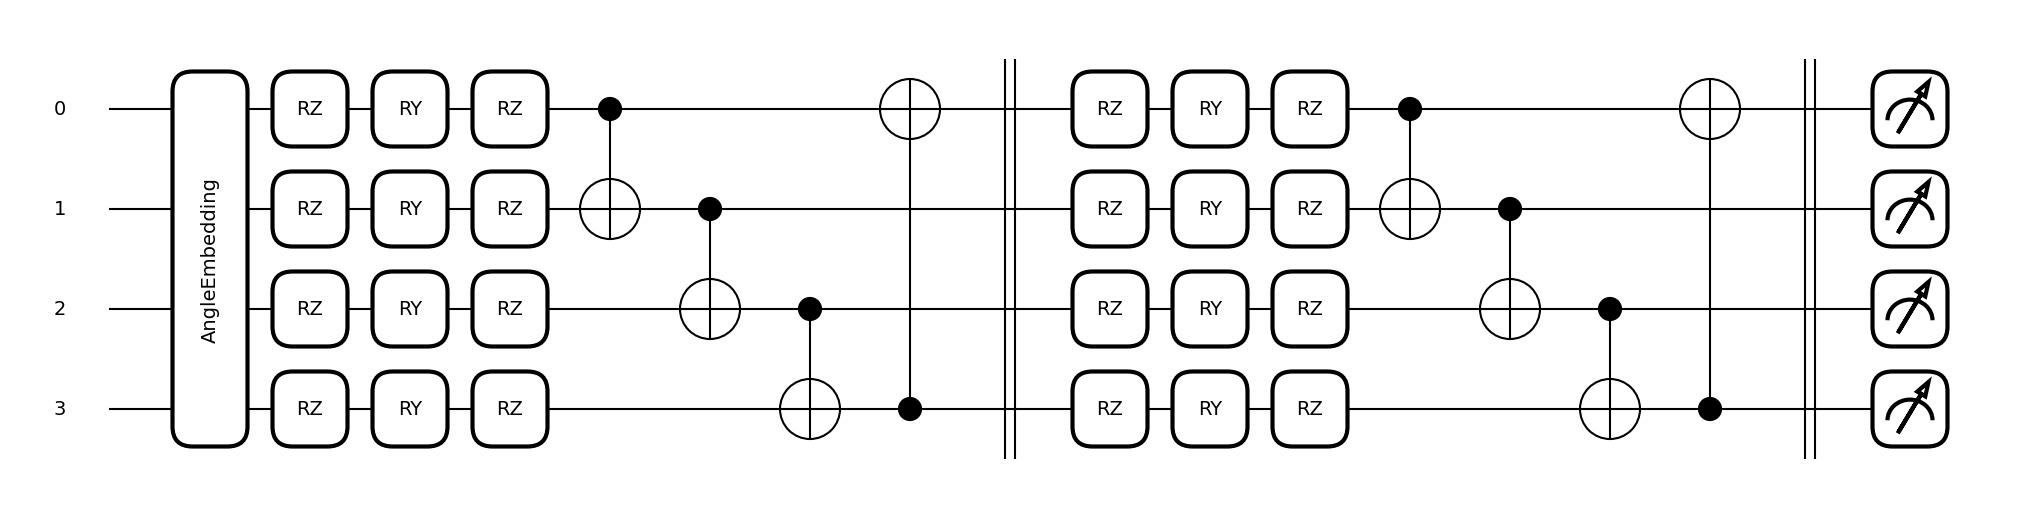

-------------------------------
Input shape to ParallelQuantumLayer: torch.Size([10, 1568])
Output shape from ParallelQuantumLayer: torch.Size([10, 20])
Expected output shape: (10, 20)


In [98]:
# --- Example of how to test this layer ---
# Hyperparameters
q = 4      # Number of qubits per circuit
c = 5      # Number of parallel circuits
depth = 2  # Depth of each circuit

# Create an instance of the layer
parallel_q_layer = ParallelQuantumLayer(
    n_qubits=q,
    n_circuits=c,
    depth=depth,
    device='lightning.qubit'
)

# Create a dummy input tensor (simulating output from the CNN block)
batch_size = 10
dummy_cnn_features = torch.randn(batch_size, 1568)

# Pass the dummy data through the layer
output_features = parallel_q_layer(dummy_cnn_features)

print(f"Input shape to ParallelQuantumLayer: {dummy_cnn_features.shape}")
print(f"Output shape from ParallelQuantumLayer: {output_features.shape}")
print(f"Expected output shape: ({batch_size}, {c * q})")

## Final Classification Layer

```
FUNCTION ClassicalDenseLayer(quantum_features):
    // Final dense layer for classification
    logits = DenseLayer(input_size=n, output_size=10)(quantum_features)
    logits = BatchNormalization(logits)
    logits = ReLU(logits)

    // Convert to probabilities
    probabilities = Softmax(logits)

    RETURN probabilities
```


In [99]:
def ClassicalDenseLayer(quantum_output_size, n_classes):
    return nn.Sequential(
        nn.Linear(quantum_output_size, n_classes),
        nn.BatchNorm1d(n_classes),
    )

In [100]:
# --- Example of how to test this layer ---
# Dummy Hyperparameters
c = 5
q = 4
n_classes = 2

# Use the output from the previous quantum layer test as input here
dummy_quantum_features = output_features

# Pass the dummy data through the layer
quantum_output_size = c * q
layer = ClassicalDenseLayer(quantum_output_size, n_classes)
final_probabilities = layer(dummy_quantum_features)

print(f"Input shape to ClassicalDenseLayer: {dummy_quantum_features.shape}")
print(f"Output shape from ClassicalDenseLayer: {final_probabilities.shape}")
print(f"Expected output shape: ({batch_size}, {n_classes})")

# Check if the output is a valid probability distribution
# The sum of probabilities for each sample in the batch should be 1.0
print(f"\nSum of probabilities for the first sample: {torch.sum(final_probabilities[0])}")
print(f"Output for the first sample: \n{final_probabilities[0].detach().numpy()}")

Input shape to ClassicalDenseLayer: torch.Size([10, 20])
Output shape from ClassicalDenseLayer: torch.Size([10, 2])
Expected output shape: (10, 2)

Sum of probabilities for the first sample: 2.5936427116394043
Output for the first sample: 
[2.0488691 0.5447735]


## Training Loop

```
ALGORITHM: Train_HQNN_Parallel
INPUT: Training dataset D, learning parameters
OUTPUT: Trained model parameters

FUNCTION TrainModel(dataset, epochs, learning_rate):
    // Initialize parameters
    classical_params = InitializeClassicalWeights()
    quantum_params = InitializeQuantumAngles()

    FOR epoch = 1 TO epochs:
        total_loss = 0

        FOR batch IN dataset:
            // Forward pass
            predictions = HQNN_Parallel(batch.images)

            // Compute cross-entropy loss
            loss = CrossEntropyLoss(predictions, batch.labels)
            total_loss += loss

            // Backward pass
            // Classical gradients via backpropagation
            classical_grads = BackwardPass(loss, classical_params)

            // Quantum gradients via parameter shift rule
            quantum_grads = ParameterShiftRule(loss, quantum_params)

            // Update parameters
            classical_params = UpdateWeights(classical_params,
                                           classical_grads, learning_rate)
            quantum_params = UpdateWeights(quantum_params,
                                         quantum_grads, learning_rate)

        PRINT("Epoch:", epoch, "Loss:", total_loss)

    RETURN classical_params, quantum_params
```


In [101]:
class HQNNParallel(nn.Module):
    def __init__(self, n_circuits, n_qubits, depth, n_classes=2, device='lightning.qubit'):
        super().__init__()

        # 1. Classical Convolutional Block
        self.classical_conv_block = ClassicalConvBlock

        # 2. Parallel Quantum Layer
        self.parallel_quantum_layer = ParallelQuantumLayer(
            n_circuits=n_circuits,
            n_qubits=n_qubits,
            depth=depth,
            device=device
        )

        # 3. Final Classical Dense Classfication Layer
        # It's best practice to output raw scores (logits) and use
        # nn.CrossEntropyLoss, which combines Softmax and NLLLoss for
        # better numerical stability.
        quantum_output_size = n_circuits * n_qubits
        self.classical_classifier = ClassicalDenseLayer(quantum_output_size, n_classes)

    def forward(self, x):
        features = self.classical_conv_block(x)

        quantum_output = self.parallel_quantum_layer(features)

        predictions = self.classical_classifier(quantum_output)

        return predictions

In [122]:
# --- Training and Evaluation Loop ---
def train_model(model, train_dataset, test_dataset, epochs=5, batch_size=32, learning_rate=0.001, plot=True):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Define accuracy metric
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=2)

    # Calculate log interval to print roughly 10 times per epoch
    log_interval = max(1, len(train_loader) // 10)
    
    # --- Live Plotting Setup (Optional) ---
    if plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx() # Create a second y-axis sharing the same x-axis

        # Initialize plot elements
        ax1.set_xlabel("Training Steps")
        ax1.set_ylabel("Loss", color='b')
        ax2.set_ylabel("Accuracy (%)", color='r')
        ax1.tick_params(axis='y', labelcolor='b')
        ax2.tick_params(axis='y', labelcolor='r')
        
        # Create empty line objects to update later
        line1, = ax1.plot([], [], 'b-', label='Training Loss')
        line2, = ax2.plot([], [], 'r.-', label='Test Accuracy')
        
        # Add a legend
        fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        
        # Display the initial plot
        plot_display = display(fig, display_id=True)
    
    # Lists to store metrics
    train_losses, train_steps = [], []
    test_accuracies, test_steps = [], []
    global_step = 0

    for epoch in range(epochs):
        model.train() # Set model to training mode
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad() # Reset gradients
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_steps.append(global_step)
            global_step += 1

            # Log progress and update plot
            if (i + 1) % log_interval == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                if plot:
                    line1.set_data(train_steps, train_losses)
                    line2.set_data(test_steps, test_accuracies)
                    ax1.relim()
                    ax1.autoscale_view()
                    ax2.relim()
                    ax2.autoscale_view()
                    plot_display.update(fig)
        
        # --- Evaluation Phase ---
        model.eval()
        accuracy_metric.reset() # Reset metric for the new epoch
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                accuracy_metric.update(outputs, labels)

        accuracy = accuracy_metric.compute().item() * 100
        test_accuracies.append(accuracy)
        test_steps.append(global_step)
        print(f'Epoch [{epoch+1}/{epochs}] - Test Accuracy: {accuracy:.2f}%')

        # --- Final Plot Update for the Epoch ---
        if plot:
            line1.set_data(train_steps, train_losses)
            line2.set_data(test_steps, test_accuracies)
            ax1.relim()
            ax1.autoscale_view()
            ax2.relim()
            ax2.autoscale_view()
            plot_display.update(fig)

    if plot:
        plt.close(fig)
    print('Finished Training')
    return model

In [82]:
# --- Prediction on New Images ---
def predict_image(model, image_tensor):
    # Now we have a proper model instance
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
        # Print probabilities for each class
        for i, prob in enumerate(probabilities[0]):
            print(f"Class {i}: {prob:.4f}")
            
        confidence, predicted_class = torch.max(probabilities, 1)

    if image_tensor.shape[0] == 1:
        return predicted_class.item(), confidence.item()
    else:
        return predicted_class.tolist(), confidence.tolist()

In [118]:
# Hyperparameters
q = 5      # Qubits
c = 4      # Circuits
depth = 6  # Depth

# WARNING: The below cell takes a long time to run, depending on the hyperparameters


--- Quantum Circuit Structure ---


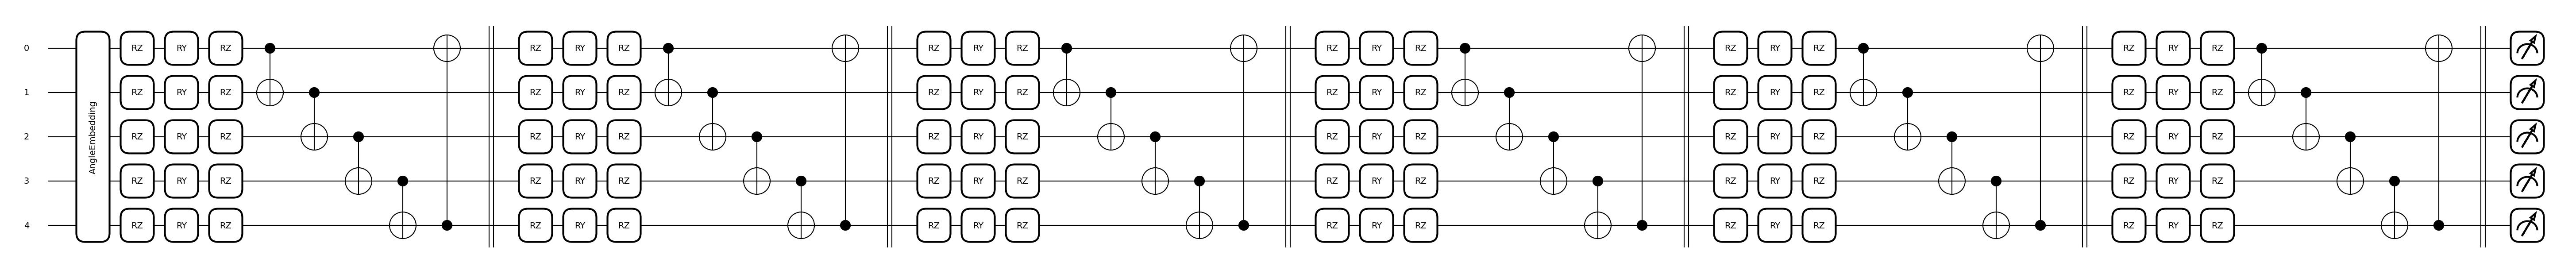

-------------------------------
Train subset size: 9999
Test subset size: 2500


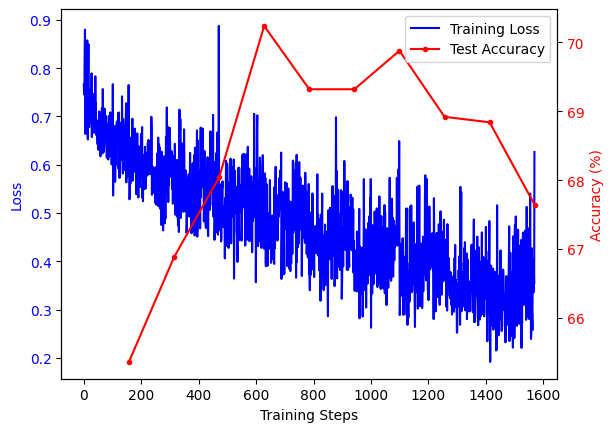

Epoch [1/10], Step [15/157], Loss: 0.6524
Epoch [1/10], Step [30/157], Loss: 0.7374
Epoch [1/10], Step [45/157], Loss: 0.6612
Epoch [1/10], Step [60/157], Loss: 0.6761
Epoch [1/10], Step [75/157], Loss: 0.6735
Epoch [1/10], Step [90/157], Loss: 0.6375
Epoch [1/10], Step [105/157], Loss: 0.6407
Epoch [1/10], Step [120/157], Loss: 0.6410
Epoch [1/10], Step [135/157], Loss: 0.6563
Epoch [1/10], Step [150/157], Loss: 0.7049
Epoch [1/10] - Test Accuracy: 65.36%
Epoch [2/10], Step [15/157], Loss: 0.6189
Epoch [2/10], Step [30/157], Loss: 0.6650
Epoch [2/10], Step [45/157], Loss: 0.6648
Epoch [2/10], Step [60/157], Loss: 0.5749
Epoch [2/10], Step [75/157], Loss: 0.5809
Epoch [2/10], Step [90/157], Loss: 0.5914
Epoch [2/10], Step [105/157], Loss: 0.5315
Epoch [2/10], Step [120/157], Loss: 0.4640
Epoch [2/10], Step [135/157], Loss: 0.6797
Epoch [2/10], Step [150/157], Loss: 0.6277
Epoch [2/10] - Test Accuracy: 66.88%
Epoch [3/10], Step [15/157], Loss: 0.4743
Epoch [3/10], Step [30/157], Loss: 0

In [124]:
transform = transforms.Compose([
     transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Force grayscale
    transforms.ToTensor(),                        # Convert to tensor
])
catdog_dataset = datasets.ImageFolder(
    root="./data/PetImages",
    transform=transform
)
hqnn_model = HQNNParallel(
    n_circuits = c,
    n_qubits = q,
    depth = depth,
    device = 'lightning.qubit'
)

# Optional: stratified train/test split
from torch.utils.data import random_split
train_size = int(0.8 * len(catdog_dataset))
test_size = len(catdog_dataset) - train_size
train_dataset, test_dataset = random_split(catdog_dataset, [train_size, test_size])

dataset_portion = 0.5

train_dataset = torch.utils.data.Subset(train_dataset, range(int(len(train_dataset) * dataset_portion)))
test_dataset = torch.utils.data.Subset(test_dataset, range(int(len(test_dataset) * dataset_portion)))
print("Train subset size:", len(train_dataset))
print("Test subset size:", len(test_dataset))

trained_model = train_model(hqnn_model, train_dataset, test_dataset, epochs=10, batch_size=64, plot=True)


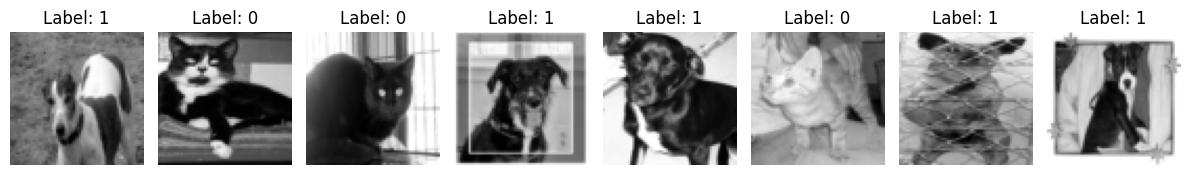

In [125]:
# import matplotlib.pyplot as plt
# import torchvision
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# Dataset and loader
dataset = datasets.ImageFolder(root="./data/PetImages", transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Get one batch
images, labels = next(iter(loader))

# Plot images
fig, axs = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axs[i].imshow(images[i][0], cmap="gray")  # images[i][0] since grayscale has shape (1, H, W)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


Saving cat data model

In [126]:
import os

# Find a unique filename to avoid overwriting existing models
base = 'hqnn_parallel_petimages_lightning_68%'
ext = '.pth'
filename = base + ext
counter = 1
# while os.path.exists(filename):
#     filename = f"{base}_{counter}{ext}"
#     counter += 1

# Save the model to a unique file
torch.save(trained_model.state_dict(), filename)
print(f"Model saved to {filename}")

Model saved to hqnn_parallel_petimages_lightning_68%.pth


In [127]:
def load_model(filepath):
    state_dict = torch.load(filepath)

    # Create a new model instance with the same architecture
    loaded_model = HQNNParallel(
        n_circuits=c,  # Using values defined elsewhere
        n_qubits=q,
        depth=depth,
        device='lightning.qubit'
    )
    # Load the state dictionary
    loaded_model.load_state_dict(state_dict)
    return loaded_model

--- Quantum Circuit Structure ---


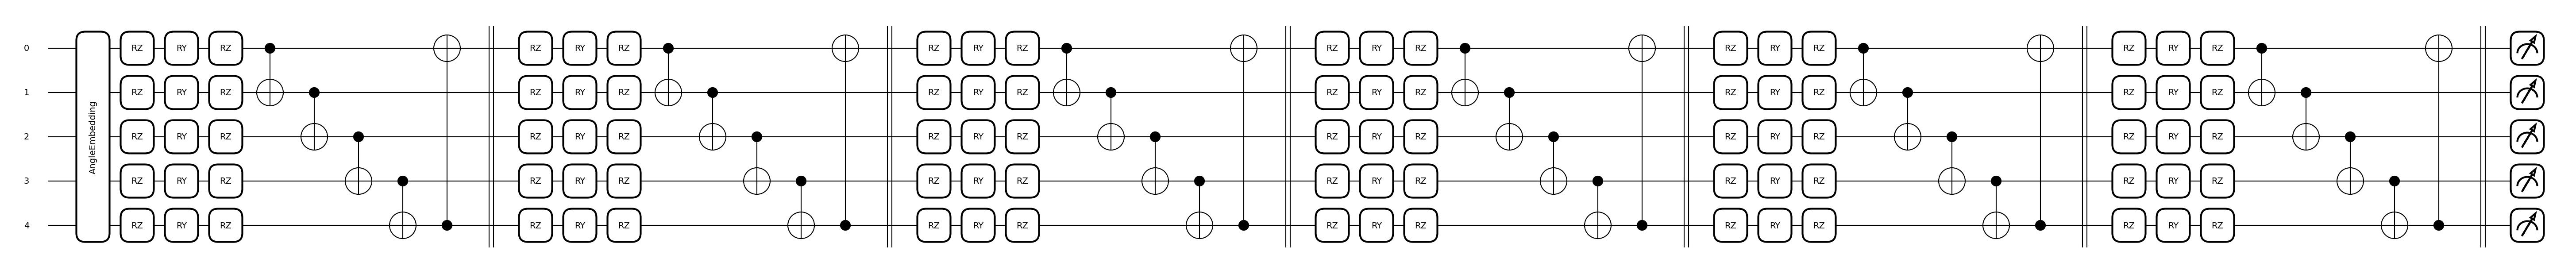

-------------------------------
Class 0: 0.9019
Class 1: 0.0981

--- Prediction ---
True Label: 0
Predicted Label: 0 with confidence 0.9019


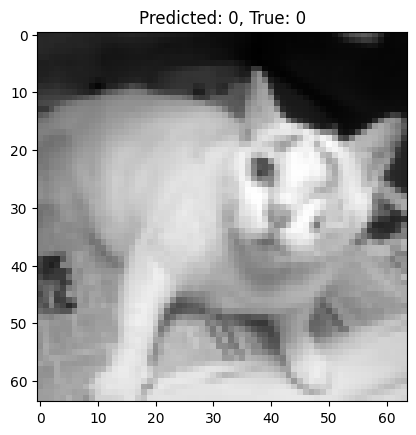

In [134]:
import random

# 4. Test prediction on a single image
# Load the model from file
model_from_path = load_model('hqnn_parallel_petimages_lightning_68%.pth')

# Select a random image from the test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
img, label = test_dataset[random_idx]
img_batch = img.unsqueeze(0)  # Add batch dimension

predicted, confidence = predict_image(model_from_path, img_batch)
print(f"\n--- Prediction ---")
print(f"True Label: {label}")
print(f"Predicted Label: {predicted} with confidence {confidence:.4f}")

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted}, True: {label}")
plt.show()